In [10]:
# Convert from weight fraction to molar fraction
from pycalphad import variables as v
from libreCalphad.databases.db_utils import load_database

dbf = load_database("unary50.tdb")

conditions = {v.W("C"): 0.0001}

v.get_mole_fractions(conditions, "FE", dbf)

{X_C: 0.0004647958139264069}

In [16]:
# Provide sublattice occupancies of a phase at a given composition
from pycalphad import equilibrium, variables as v
from libreCalphad.databases.db_utils import load_database

dbf = load_database("mf-steel.tdb")

components = ["C", "FE", "VA"]
phase = ["FCC_A1"]
conditions = {v.N: 1, v.T: 1000, v.W("C"): 0.0001}

equilibrium(dbf,components,phase,conditions).sel(component="C").Y

<xarray.DataArray 'Y' (N: 1, T: 1, W_C: 1, vertex: 3, internal_dof: 3)> Size: 72B
array([[[[[1.00000000e+00, 4.65011950e-04, 9.99534988e-01],
          [           nan,            nan,            nan],
          [           nan,            nan,            nan]]]]])
Coordinates:
  * N          (N) float64 8B 1.0
  * T          (T) float64 8B 1e+03
  * W_C        (W_C) float64 8B 0.0001
  * vertex     (vertex) int64 24B 0 1 2
    component  <U2 8B 'C'
Dimensions without coordinates: internal_dof

In [47]:
import pandas as pd
import pycalphad.variables as v
from libreCalphad.databases.db_utils import load_database

dbf = load_database("mf-steel.tdb")
df = pd.read_csv("./zpf/C-FE/Mehl1937/Mehl1937-Fig44-Fe-Fe3C-phase-diagram.csv", skiprows=[1])
convert_dict = {"A3": "C", "Unnamed: 3": "temp", "Acm": "C", "Unnamed: 5": "temp"}

def convert_col(row, convert_dict, dbf):
    for key, value in convert_dict.items():
        if value == "temp":
            row[f"{key}-K"] = row[key] + 273.15
        else:
            conditions = {v.W(value): row[key]/100}
            row[f"{key}-X_{value}"] = v.get_mole_fractions(conditions, "FE", dbf)[v.X(value)]
    return row

df = df.apply(lambda row: convert_col(row, convert_dict, dbf), axis=1)
df.to_csv("./zpf/C-FE/Mehl1937/Mehl1937-Fig44-Fe-Fe3C-phase-diagram-converted.csv")

In [144]:
import json
import pandas as pd
import pycalphad.variables as v
from libreCalphad.databases.db_utils import load_database

dbf = load_database("mf-steel.tdb")
out_dict = {"components": ["C", "FE"],
            "phases": ["BCC_A2", "FCC_A1", "CEMENTITE_D011"],
            "reference": "Mehl (1937)",
            "bibtex": "Mehl1937",
            "weight": 1}
conditions = {"P": 101325}
values_dict = {1: {"temperatures": {"column": "Unnamed: 3", "units": "degC"}, 1: {"phase": "BCC_A2", "component": "C", "values": "null", "units": "weight_percent"}, 2: {"phase": "FCC_A1", "component": "C", "values": "A3", "units": "weight_percent"}},
          2: {"temperatures": {"column": "Unnamed: 5", "units": "degC"}, 1: {"phase": "BCC_A2", "component": "C", "values": "Acm", "units": "weight_percent"}, 2: {"phase": "CEMENTITE_D011", "component": "C", "values": "null", "units": "weight_percent"}}
          }
df = pd.read_csv("./zpf/C-FE/Mehl1937/Mehl1937-Fig44-Fe-Fe3C-phase-diagram.csv", skiprows=[1])

def write_zpf_json(components, phases, conditions, values_dict, input_df, broadcast_conditions=False, output="ZPF"):
    out_dict = {
        "components": components,
        "phases": phases,
        "broadcast_conditions": broadcast_conditions,
        "output": "ZPF",
        }
    values_string = []
    for segment, value in values_dict.items():
        temperatures = input_df[input_df[value["temperatures"]["column"]].notnull()][value["temperatures"]["column"]].values
        temp_unit = value["temperatures"]["units"]
        if temp_unit == "degC":
            temperatures += 273.15
        if "T" not in list(conditions.keys()):
            conditions["T"] = list(temperatures)
        else:
            conditions["T"].extend(list(temperatures))
        for i in range(len(temperatures)):
            temp_output = []
            segment_no = 0
            seg_nan = False
            for segment_key, segment_values in value.items():
                segment_output = []
                if segment_key == "temperatures":
                    segment_no += 1
                    continue
                else:
                    # segment_output += f"['{segment_values['phase']}', "
                    segment_output.append(segment_values["phase"])
                    ind_component = segment_values["component"]
                    # segment_output += f"['{ind_component}'], "
                    segment_output.append([ind_component])
                    if segment_values["values"] != "null":
                        concentration = input_df.loc[i][segment_values["values"]]
                        if pd.isnull(concentration):  # blank values from WPD will be NaN
                            seg_nan = True
                            continue
                        elif segment_values["units"] == "weight_percent":
                            concentration = concentration / 100  # convert to weight fraction
                            if len(components) == 2:
                                dependent_component = [comp for comp in components if comp != ind_component][0]
                                conc_conditions = {v.W(ind_component): concentration}
                                concentration = v.get_mole_fractions(conc_conditions, dependent_component, dbf)[v.X(ind_component)]
                        # segment_output += f"[{concentration}]"
                    else:
                        # segment_output += "[null]"
                        # TODO: Figure out how to properly output null to the JSON file.
                        concentration = None
                    segment_output.append([concentration])
                # if segment_no == len(value.keys())-1:
                #     segment_output += "]],"
                # else:
                #     segment_output += "], "
                # temp_output += segment_output
                temp_output.append(segment_output)
                segment_no += 1
            # temp_output += "\n"
            if not seg_nan:
                # values_string += temp_output
                values_string.append(temp_output)
    return conditions, values_string
            
        

conditions, values = write_zpf_json(components, phases, conditions, values_dict, df)
out_dict["conditions"] = conditions
out_dict["output"] = "ZPF"
out_dict["values"] = values
with open("./zpf/C-FE/Mehl1937/temp_out.json", "w") as f:
    json.dump(out_dict, f)

In [14]:
# C_ratio conversion

import numpy as np
from scipy.optimize import minimize

def convert_c_ratio(y_c):

    def calc_c_ratio(x_c):
        x_fe = 1-x_c
        return x_c/x_fe

    return minimize(lambda x: np.abs(y_c-calc_c_ratio(x)), x0=y_c_vals[0]).x[0]
convert_c_ratio(0.3)

np.float64(0.2307692279064811)

In [23]:
# Convert from cal / gram-atomic to J/mol

import numpy as np

molar_masses = {"C": 12.011, "FE": 55.845}
conditions = {"C": 0.25}
conditions["FE"] = 1 - np.sum(list(conditions.values()))
sample_masses = {}

for key, value in conditions.items():
    sample_masses[key] = conditions[key]*molar_masses[key]

alloy_molar_mass  = np.sum(list(sample_masses.values()))

cal_to_J = 4.1868

measurement = 23951
measurement / alloy_molar_mass * cal_to_J

np.float64(2234.035774676128)

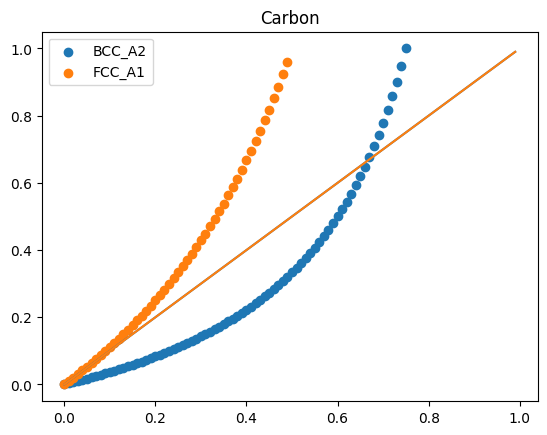

In [11]:
# Explore site fraction vs atomic fraction
from libreCalphad.databases.db_utils import load_database
import matplotlib.pyplot as plt
from pycalphad import equilibrium, variables as v

dbf = load_database("mf-steel.tdb")
phases = ["BCC_A2", "FCC_A1"]
components = ["FE", "C", "VA"]
conditions = {v.N: 1, v.P: 101325, v.T: 500, v.X("C"): (0, 1, 0.01)}
num_sites = {"BCC_A2": [1,3], "FCC_A1": [1,1]}
site_fracs = {}
for x_c in conditions[v.X("C")]:
    site_fracs["BCC_A2"]
fig, ax = plt.subplots()

for phase in phases:
    eq = equilibrium(dbf, components, phase, conditions)
    ax.scatter(eq.X_C, eq.Y.sel(vertex=0).squeeze()[:,1], label=phase)
    ax.plot(eq.X_C, )
    ax.set_title("Carbon")

ax.legend()


In [16]:
# Explore site fraction vs atomic fraction
from libreCalphad.databases.db_utils import load_database
import matplotlib.pyplot as plt
from pycalphad import calculate, Model, variables as v

dbf = load_database("lc-steels-input.tdb")
phases = ["BCC_A2", "FCC_A1"]
components = ["FE", "C", "VA"]
conditions = {v.N: 1, v.P: 101325, v.T: 300, v.X("C"): 0.01}

eq = equilibrium(dbf, components, "BCC_A2", conditions)
eq.Y

/Users/mattfrichtl/opt/pycalphad/pycalphad/io/tdb.py:1377: UserWarning: The type definition character `%` was defined in the following phases: ['BCC_A2', 'CEMENTITE_D011', 'FCC_A1'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(


<xarray.DataArray 'Y' (N: 1, P: 1, T: 1, X_C: 1, vertex: 3, internal_dof: 3)> Size: 72B
array([[[[[[1.      , 0.003367, 0.996633],
           [     nan,      nan,      nan],
           [     nan,      nan,      nan]]]]]])
Coordinates:
  * N        (N) float64 8B 1.0
  * P        (P) float64 8B 1.013e+05
  * T        (T) float64 8B 300.0
  * X_C      (X_C) float64 8B 0.01
  * vertex   (vertex) int64 24B 0 1 2
Dimensions without coordinates: internal_dof


=== Fitted temperature‑independent part (a_k) ===
a_0 =  4502.46 J·mol⁻¹
a_1 = -989.95 J·mol⁻¹
a_2 = -1059.04 J·mol⁻¹

=== Fitted temperature‑dependent slopes (b_k) ===
b_0 =  4.9937 J·mol⁻¹·K⁻¹
b_1 = -1.5293 J·mol⁻¹·K⁻¹
b_2 =  1.6915 J·mol⁻¹·K⁻¹

RMS residual on G_ex = 18.60 J·mol⁻¹


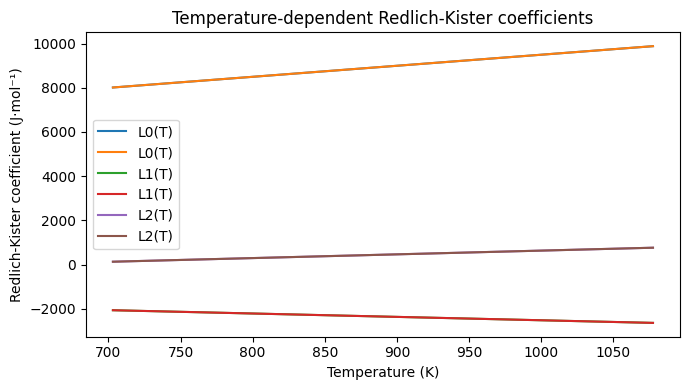

In [ ]:
# ==============================================================
# 0️⃣  Imports & global constants
# ==============================================================

import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Optional, Union

# pycalphad imports
from pycalphad import Database, Model, equilibrium
from pycalphad import variables as v

R_J = 8.314462618               # J·mol‑1·K‑1


# ==============================================================
# 1️⃣  CALPHAD reference‑state Gibbs energy (supports custom phase)
# ==============================================================

def ref_gibbs_energy(db_path: Union[str, Database],
                     element: str,
                     temperature: float,
                     phase_name: Optional[str] = None,
                     pressure: float = 101325.0) -> float:
    """
    Return the molar Gibbs energy (J/mol) of a pure element.

    Parameters
    ----------
    db_path : str | pycalphad.Database
        Path to the CALPHAD database or a pre‑loaded Database object.
    element : str
        Chemical symbol, e.g. "Fe".
    temperature : float
        Temperature in Kelvin.
    phase_name : str, optional
        Name of the phase that represents the pure element.
        If None, the first available phase is used.
    pressure : float, optional
        Pressure in Pascal (default = 1 atm).

    Returns
    -------
    g_ref : float
        Molar Gibbs energy of the pure element (J/mol).
    """
    # Load or reuse the database
    if isinstance(db_path, str):
        db = Database(db_path)
    else:
        db = db_path

    # Choose the reference phase
    if phase_name is None:
        phase_name = "ELEMENT" if "ELEMENT" in db.phases else list(db.phases.keys())[0]
    else:
        if phase_name not in db.phases:
            raise KeyError(f"Phase '{phase_name}' not found in database. "
                           f"Available: {list(db.phases.keys())}")

    # Build a model for the pure element (single sublattice, single species)
    # NOTE: we include a vacancy species ("VA") because many unary databases
    # define the pure element as a sublattice with X(element) + VA.
    comps = [element, "VA"]
    res = equilibrium(db,
                      comps=comps,
                      phases=[phase_name],
                      conditions={v.T: temperature, v.P: pressure},
                      output="GM")

    # The result is a DataArray with dimensions (T, P).  Squeeze to a scalar.
    g_ref = float(res.GM.squeeze().values)
    return g_ref


# ==============================================================
# 2️⃣  Redlich‑Kister activity‑coefficient calculator (unchanged)
# ==============================================================

def rk_gamma(x_a: float,
             temperature: float,
             L_vals: List[float]) -> Tuple[float, float]:
    """Return (γ_A, γ_B) for a binary solid solution."""
    if not (0.0 < x_a < 1.0):
        raise ValueError("x_a must be between 0 and 1.")
    x_b = 1.0 - x_a
    delta = x_a - x_b                     # = 2·x_a – 1

    g_ex = sum(Lk * (delta ** k) for k, Lk in enumerate(L_vals))
    g_ex *= x_a * x_b

    deriv = sum((k + 1) * Lk * (delta ** k) for k, Lk in enumerate(L_vals))

    ln_gamma_a = (g_ex / (R_J * temperature)) + (x_b ** 2) * deriv / (R_J * temperature)
    ln_gamma_b = (g_ex / (R_J * temperature)) + (x_a ** 2) * deriv / (R_J * temperature)

    return np.exp(ln_gamma_a), np.exp(ln_gamma_b)


# ==============================================================
# 3️⃣  Convert activities → excess Gibbs (uses CALPHAD refs)
# ==============================================================

def excess_gibbs_from_activities(row: pd.Series,
                                 db_path: Union[str, Database],
                                 elem_phase_map: Dict[str, str],
                                 element_A: str,
                                 element_B: str,
                                 provisional_L: Optional[List[float]] = None) -> float:
    """
    Compute excess Gibbs energy (J/mol) for a single measurement.
    """
    T   = float(row["T"])
    x_a = float(row["x_A"])
    x_b = 1.0 - x_a
    a_a = float(row["a_A"])

    # ----- activity of B -------------------------------------------------
    if "a_B" in row and pd.notna(row["a_B"]):
        a_b = float(row["a_B"])
    else:
        if provisional_L is None:
            a_b = x_b                     # ideal B
        else:
            _, gamma_b = rk_gamma(x_a, T, provisional_L)
            a_b = gamma_b * x_b

    # ----- Reference Gibbs energies (user‑supplied phases) -------------
    phase_A = elem_phase_map.get(element_A)   # may be None → fallback inside ref_gibbs_energy
    phase_B = elem_phase_map.get(element_B)

    g_ref_a = ref_gibbs_energy(db_path, element=element_A,
                               temperature=T, phase_name=phase_A)
    g_ref_b = ref_gibbs_energy(db_path, element=element_B,
                               temperature=T, phase_name=phase_B)

    # ----- Convert absolute activities to activity coefficients ----------
    gamma_a = a_a / x_a
    gamma_b = a_b / x_b

    # ----- Equation (1): G_ex = RT[ x_a*ln(gamma_a) + x_b*ln(gamma_b) ] ---
    term_a = x_a * np.log(gamma_a) if gamma_a > 0 else 0.0
    term_b = x_b * np.log(gamma_b) if gamma_b > 0 else 0.0
    g_ex   = R_J * T * (term_a + term_b)

    # (Optional) absolute mixture Gibbs energy:
    # G_mix = x_a * g_ref_a + x_b * g_ref_b + g_ex

    return g_ex


# ==============================================================
# 4️⃣  Design‑matrix builders
# ==============================================================

def rk_design_matrix(delta_x: np.ndarray, order: int) -> np.ndarray:
    """Columns: [1, Δx, Δx², …, Δx^order] (temperature‑independent)."""
    cols = [delta_x ** p for p in range(order + 1)]
    return np.column_stack(cols)


def rk_design_matrix_temp(delta_x: np.ndarray,
                         temperature: np.ndarray,
                         order: int) -> np.ndarray:
    """
    Columns (in order):
        1, Δx, Δx², …, Δx^order,
        T, T·Δx, T·Δx², …, T·Δx^order
    """
    a_cols = [delta_x ** p for p in range(order + 1)]
    b_cols = [temperature * (delta_x ** p) for p in range(order + 1)]
    return np.column_stack(a_cols + b_cols)


# ==============================================================
# 5️⃣  Load CSV/Excel and rename columns according to user mapping
# ==============================================================

def load_and_rename(filepath: str,
                    col_map: Dict[str, str]) -> pd.DataFrame:
    """
    Read a CSV or Excel file and rename its columns to the canonical names:
    'T', 'x_A', 'x_B', 'a_A', 'a_B'.
    """
    if filepath.lower().endswith(('.xlsx', '.xls')):
        df = pd.read_excel(filepath)
    else:
        df = pd.read_csv(filepath)

    # Invert mapping: actual_name → canonical_name
    inv_map = {v: k for k, v in col_map.items()}
    df = df.rename(columns=inv_map)

    # Auto‑create x_B if missing
    if "x_B" not in df.columns and "x_A" in df.columns:
        df["x_B"] = 1.0 - df["x_A"]
    return df


# ==============================================================
# 6️⃣  Core fitting routine – temperature‑dependent RK
# ==============================================================

def fit_rk_temp_dependent(df: pd.DataFrame,
                          db_path: Union[str, Database],
                          element_A: str,
                          element_B: str,
                          elem_phase_map: Dict[str, str],
                          order: int = 2,
                          provisional_L: Optional[List[float]] = None) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Fit L_k(T) = a_k + b_k·T to activity‑derived excess Gibbs data.

    Returns
    -------
    a_vec : ndarray
        Temperature‑independent coefficients (a_0 … a_N) [J·mol⁻¹].
    b_vec : ndarray
        Temperature‑dependent slopes (b_0 … b_N) [J·mol⁻¹·K⁻¹].
    diagnostics : DataFrame
        Original G_ex, predicted G_ex, residuals, and the instantaneous
        L_k(T) values for each measurement.
    """
    df = df.copy()

    # ----- 1) Compute G_ex for every row (CALPHAD references) ----------
    df["G_ex"] = df.apply(
        lambda r: excess_gibbs_from_activities(r,
                                              db_path,
                                              elem_phase_map,
                                              element_A,
                                              element_B,
                                              provisional_L),
        axis=1,
    )

    # ----- 2) Remove pure‑component points (x_A = 0 or 1) ---------------
    mask = (df["x_A"] > 0) & (df["x_A"] < 1)
    if not mask.all():
        print("Warning: pure‑component points removed from the fit.")
    df = df.loc[mask]

    # ----- 3) Linearised variables ------------------------------------
    df["x_B"] = 1.0 - df["x_A"]
    df["delta_x"] = df["x_A"] - df["x_B"]          # = 2·x_A – 1
    df["y"] = df["G_ex"] / (df["x_A"] * df["x_B"])

    X = rk_design_matrix_temp(df["delta_x"].values,
                              df["T"].values,
                              order)                     # (n, 2*(order+1))
    y = df["y"].values

    # ----- 4) Least‑squares solution -----------------------------------
    beta, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)

    n_coeff = order + 1
    a_vec = beta[:n_coeff]          # a_0 … a_N
    b_vec = beta[n_coeff:]          # b_0 … b_N

    # ----- 5) Re‑construct G_ex_pred using temperature‑dependent L_k(T) ----
    # Compute L_k(T) for each measurement
    L_T = np.zeros((len(df), n_coeff))
    for k in range(n_coeff):
        L_T[:, k] = a_vec[k] + b_vec[k] * df["T"].values

    # Build Δx^k matrix
    delta_pow = np.vstack([df["delta_x"].values ** p for p in range(n_coeff)]).T
    g_ex_pred = (df["x_A"] * df["x_B"]).values * np.sum(L_T * delta_pow, axis=1)

    df["G_ex_pred"] = g_ex_pred
    df["residual"]  = df["G_ex"] - df["G_ex_pred"]

    # ----- 6) Attach the instantaneous L_k(T) values to the diagnostics df ----
    coeffs_per_point = pd.DataFrame(L_T,
                                    columns=[f"L{k}" for k in range(n_coeff)],
                                    index=df.index)
    coeffs_per_point["T"] = df["T"]
    df = pd.concat([df, coeffs_per_point], axis=1)

    return a_vec, b_vec, df


# ==============================================================
# 7️⃣  Example workflow (synthetic data with temperature dependence)
# ==============================================================

if __name__ == "__main__":
    # --------------------------------------------------------------
    # 0. Load a CALPHAD database (replace with your own file)
    # --------------------------------------------------------------
    from libreCalphad.databases.db_utils import load_database
    db = load_database("unary50.tdb")          # <-- edit as needed

    # --------------------------------------------------------------
    # 1. Synthetic data – true temperature‑dependent RK coefficients
    # --------------------------------------------------------------
    rng = np.random.default_rng(2024)

    # True a_k (temperature‑independent) and b_k (slope) values
    a_true = np.array([ 4500.0, -1000.0, 200.0 ])   # J/mol
    b_true = np.array([   5.0,   -1.5,   0.3 ])   # J/mol/K

    order = len(a_true) - 1
    n_pts = 40
    x_a   = rng.uniform(0.05, 0.95, size=n_pts)
    T     = rng.uniform(700, 1100, size=n_pts)    # wide temperature range

    delta = 2.0 * x_a - 1.0
    # Build L_k(T) for each point
    L_T = np.array([a_true[k] + b_true[k] * T for k in range(order + 1)]).T
    G_ex_true = x_a * (1 - x_a) * np.sum(L_T * (delta[:, None] ** np.arange(order + 1)), axis=1)

    # Add experimental noise (±20 J/mol)
    G_ex_noisy = G_ex_true + rng.normal(scale=20.0, size=n_pts)

    # Convert noisy G_ex back to activities (assume ideal B)
    a_B = 1.0 - x_a
    ln_ratio_A = (G_ex_noisy / (R_J * T) - (1 - x_a) * np.log(a_B / (1 - x_a))) / x_a
    a_A = x_a * np.exp(ln_ratio_A)

    # Assemble a DataFrame with custom column names
    df_raw = pd.DataFrame({
        "Temp_K":      T,
        "MolFrac_A":   x_a,
        "Act_A":       a_A,
        "Act_B":       a_B,          # optional – could be omitted
    })
    csv_path = "synthetic_temp_dep.csv"
    df_raw.to_csv(csv_path, index=False)

    # --------------------------------------------------------------
    # 2. Column‑name mapping (canonical → actual)
    # --------------------------------------------------------------
    col_map = {
        "T"   : "Temp_K",
        "x_A" : "MolFrac_A",
        "a_A" : "Act_A",
        "a_B" : "Act_B",          # optional – omit if not present
    }

    # --------------------------------------------------------------
    # 3. Load and rename
    # --------------------------------------------------------------
    df_loaded = load_and_rename(csv_path, col_map)

    # --------------------------------------------------------------
    # 4. Element → reference‑phase map (adjust to your database)
    # --------------------------------------------------------------
    elem_phase_map = {
        "FE": "FCC_A1",   # pure Fe phase in the database
        "NI": "FCC_A1",   # pure Ni phase in the database
    }

    # --------------------------------------------------------------
    # 5. Fit the temperature‑dependent Redlich‑Kister model
    # --------------------------------------------------------------
    a_fit, b_fit, diagnostics = fit_rk_temp_dependent(df_loaded,
                                                      db_path=db,
                                                      element_A="FE",
                                                      element_B="NI",
                                                      elem_phase_map=elem_phase_map,
                                                      order=2)

    # --------------------------------------------------------------
    # 6. Report results
    # --------------------------------------------------------------
    print("\n=== Fitted temperature‑independent part (a_k) ===")
    for k, val in enumerate(a_fit):
        print(f"a_{k} = {val: .2f} J·mol⁻¹")

    print("\n=== Fitted temperature‑dependent slopes (b_k) ===")
    for k, val in enumerate(b_fit):
        print(f"b_{k} = {val: .4f} J·mol⁻¹·K⁻¹")

    rms = np.sqrt(np.mean(diagnostics["residual"]**2))
    print(f"\nRMS residual on G_ex = {rms:.2f} J·mol⁻¹")

    # --------------------------------------------------------------
    # 7. (Optional) Visualise L_k(T) curves
    # --------------------------------------------------------------
    import matplotlib.pyplot as plt

    plt.figure(figsize=(7, 4))
    T_plot = np.linspace(diagnostics["T"].min(),
                         diagnostics["T"].max(), 300)

    for k in range(len(a_fit)):
        L_plot = a_fit[k] + b_fit[k] * T_plot
        plt.plot(T_plot, L_plot, label=f"L{k}(T)")

    plt.xlabel("Temperature (K)")
    plt.ylabel("Redlich‑Kister coefficient (J·mol⁻¹)")
    plt.title("Temperature‑dependent Redlich‑Kister coefficients")
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Fitted temperature‑independent part (a_k) ===
a_0 =  4502.46 J·mol⁻¹
a_1 = -989.95 J·mol⁻¹
a_2 = -1059.04 J·mol⁻¹

=== Fitted temperature‑dependent slopes (b_k) ===
b_0 =  4.9937 J·mol⁻¹·K⁻¹
b_1 = -1.5293 J·mol⁻¹·K⁻¹
b_2 =  1.6915 J·mol⁻¹·K⁻¹

RMS residual on G_ex = 18.60 J·mol⁻¹


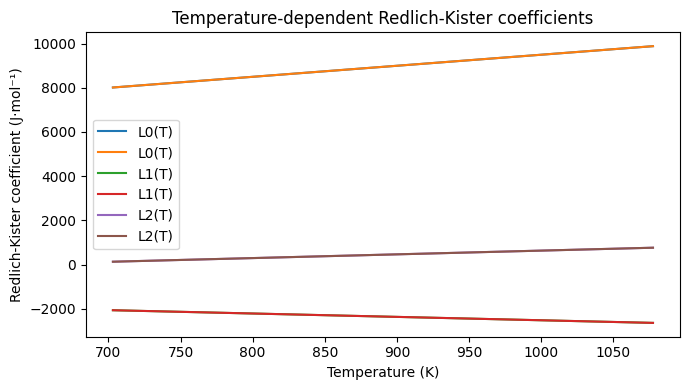

In [3]:
# ==============================================================
# 0️⃣  Imports & global constants
# ==============================================================

import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Optional, Union

# pycalphad imports
from pycalphad import Database, Model, equilibrium
from pycalphad import variables as v

R_J = 8.314462618               # J·mol‑1·K‑1


# ==============================================================
# 1️⃣  CALPHAD reference‑state Gibbs energy (supports custom phase)
# ==============================================================

def ref_gibbs_energy(db_path: Union[str, Database],
                     element: str,
                     temperature: float,
                     phase_name: Optional[str] = None,
                     pressure: float = 101325.0) -> float:
    """
    Return the molar Gibbs energy (J/mol) of a pure element.

    Parameters
    ----------
    db_path : str | pycalphad.Database
        Path to the CALPHAD database or a pre‑loaded Database object.
    element : str
        Chemical symbol, e.g. "Fe".
    temperature : float
        Temperature in Kelvin.
    phase_name : str, optional
        Name of the phase that represents the pure element.
        If None, the first available phase is used.
    pressure : float, optional
        Pressure in Pascal (default = 1 atm).

    Returns
    -------
    g_ref : float
        Molar Gibbs energy of the pure element (J/mol).
    """
    # Load or reuse the database
    if isinstance(db_path, str):
        db = Database(db_path)
    else:
        db = db_path

    # Choose the reference phase
    if phase_name is None:
        phase_name = "ELEMENT" if "ELEMENT" in db.phases else list(db.phases.keys())[0]
    else:
        if phase_name not in db.phases:
            raise KeyError(f"Phase '{phase_name}' not found in database. "
                           f"Available: {list(db.phases.keys())}")

    # Build a model for the pure element (single sublattice, single species)
    # NOTE: we include a vacancy species ("VA") because many unary databases
    # define the pure element as a sublattice with X(element) + VA.
    comps = [element, "VA"]
    res = equilibrium(db,
                      comps=comps,
                      phases=[phase_name],
                      conditions={v.T: temperature, v.P: pressure},
                      output="GM")

    # The result is a DataArray with dimensions (T, P).  Squeeze to a scalar.
    g_ref = float(res.GM.squeeze().values)
    return g_ref


# ==============================================================
# 2️⃣  Redlich‑Kister activity‑coefficient calculator (unchanged)
# ==============================================================

def rk_gamma(x_a: float,
             temperature: float,
             L_vals: List[float]) -> Tuple[float, float]:
    """Return (γ_A, γ_B) for a binary solid solution."""
    if not (0.0 < x_a < 1.0):
        raise ValueError("x_a must be between 0 and 1.")
    x_b = 1.0 - x_a
    delta = x_a - x_b                     # = 2·x_a – 1

    g_ex = sum(Lk * (delta ** k) for k, Lk in enumerate(L_vals))
    g_ex *= x_a * x_b

    deriv = sum((k + 1) * Lk * (delta ** k) for k, Lk in enumerate(L_vals))

    ln_gamma_a = (g_ex / (R_J * temperature)) + (x_b ** 2) * deriv / (R_J * temperature)
    ln_gamma_b = (g_ex / (R_J * temperature)) + (x_a ** 2) * deriv / (R_J * temperature)

    return np.exp(ln_gamma_a), np.exp(ln_gamma_b)


# ==============================================================
# 3️⃣  Convert activities → excess Gibbs (uses CALPHAD refs)
# ==============================================================

def excess_gibbs_from_activities(row: pd.Series,
                                 db_path: Union[str, Database],
                                 elem_phase_map: Dict[str, str],
                                 element_A: str,
                                 element_B: str,
                                 provisional_L: Optional[List[float]] = None) -> float:
    """
    Compute excess Gibbs energy (J/mol) for a single measurement.
    """
    T   = float(row["T"])
    x_a = float(row["x_A"])
    x_b = 1.0 - x_a
    a_a = float(row["a_A"])

    # ----- activity of B -------------------------------------------------
    if "a_B" in row and pd.notna(row["a_B"]):
        a_b = float(row["a_B"])
    else:
        if provisional_L is None:
            a_b = x_b                     # ideal B
        else:
            _, gamma_b = rk_gamma(x_a, T, provisional_L)
            a_b = gamma_b * x_b

    # ----- Reference Gibbs energies (user‑supplied phases) -------------
    phase_A = elem_phase_map.get(element_A)   # may be None → fallback inside ref_gibbs_energy
    phase_B = elem_phase_map.get(element_B)

    g_ref_a = ref_gibbs_energy(db_path, element=element_A,
                               temperature=T, phase_name=phase_A)
    g_ref_b = ref_gibbs_energy(db_path, element=element_B,
                               temperature=T, phase_name=phase_B)

    # ----- Convert absolute activities to activity coefficients ----------
    gamma_a = a_a / x_a
    gamma_b = a_b / x_b

    # ----- Equation (1): G_ex = RT[ x_a*ln(gamma_a) + x_b*ln(gamma_b) ] ---
    term_a = x_a * np.log(gamma_a) if gamma_a > 0 else 0.0
    term_b = x_b * np.log(gamma_b) if gamma_b > 0 else 0.0
    g_ex   = R_J * T * (term_a + term_b)

    # (Optional) absolute mixture Gibbs energy:
    # G_mix = x_a * g_ref_a + x_b * g_ref_b + g_ex

    return g_ex


# ==============================================================
# 4️⃣  Design‑matrix builders
# ==============================================================

def rk_design_matrix(delta_x: np.ndarray, order: int) -> np.ndarray:
    """Columns: [1, Δx, Δx², …, Δx^order] (temperature‑independent)."""
    cols = [delta_x ** p for p in range(order + 1)]
    return np.column_stack(cols)


def rk_design_matrix_temp(delta_x: np.ndarray,
                         temperature: np.ndarray,
                         order: int) -> np.ndarray:
    """
    Columns (in order):
        1, Δx, Δx², …, Δx^order,
        T, T·Δx, T·Δx², …, T·Δx^order
    """
    a_cols = [delta_x ** p for p in range(order + 1)]
    b_cols = [temperature * (delta_x ** p) for p in range(order + 1)]
    return np.column_stack(a_cols + b_cols)


# ==============================================================
# 5️⃣  Load CSV/Excel and rename columns according to user mapping
# ==============================================================

def load_and_rename(filepath: str,
                    col_map: Dict[str, str]) -> pd.DataFrame:
    """
    Read a CSV or Excel file and rename its columns to the canonical names:
    'T', 'x_A', 'x_B', 'a_A', 'a_B'.
    """
    if filepath.lower().endswith(('.xlsx', '.xls')):
        df = pd.read_excel(filepath)
    else:
        df = pd.read_csv(filepath)

    # Invert mapping: actual_name → canonical_name
    inv_map = {v: k for k, v in col_map.items()}
    df = df.rename(columns=inv_map)

    # Auto‑create x_B if missing
    if "x_B" not in df.columns and "x_A" in df.columns:
        df["x_B"] = 1.0 - df["x_A"]
    return df


# ==============================================================
# 6️⃣  Core fitting routine – temperature‑dependent RK
# ==============================================================

def fit_rk_temp_dependent(df: pd.DataFrame,
                          db_path: Union[str, Database],
                          element_A: str,
                          element_B: str,
                          elem_phase_map: Dict[str, str],
                          RK_order: int = 2,
                          provisional_L: Optional[List[float]] = None) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame]:
    """
    Fit L_k(T) = a_k + b_k·T to activity‑derived excess Gibbs data for binary solutions.

    Parameters
    ----------
    df : pandas.DataFrame
        Prepared input data.
    db_path : string | pycalphad Database object
        The thermodynamic database to use for reference states.
    element_A : string
        2-letter string for element A
    element_B : string
        2-letter string for element B
    elem_phase_map : dictionary
        Dictionary with element keys and phase values for element_A and element_B reference states.
    RK_order : int
        The order to use for the Redlich-Kister expansion.

    Returns
    -------
    a_vec : ndarray
        Temperature‑independent coefficients (a_0 … a_N) [J·mol⁻¹].
    b_vec : ndarray
        Temperature‑dependent slopes (b_0 … b_N) [J·mol⁻¹·K⁻¹].
    diagnostics : DataFrame
        Original G_ex, predicted G_ex, residuals, and the instantaneous
        L_k(T) values for each measurement.
    """
    df = df.copy()

    # ----- 1) Compute G_ex for every row (CALPHAD references) ----------
    df["G_ex"] = df.apply(
        lambda r: excess_gibbs_from_activities(r,
                                              db_path,
                                              elem_phase_map,
                                              element_A,
                                              element_B,
                                              provisional_L),
        axis=1,
    )

    # ----- 2) Remove pure‑component points (x_A = 0 or 1) ---------------
    mask = (df["x_A"] > 0) & (df["x_A"] < 1)
    if not mask.all():
        print("Warning: pure‑component points removed from the fit.")
    df = df.loc[mask]

    # ----- 3) Linearised variables ------------------------------------
    df["x_B"] = 1.0 - df["x_A"]
    df["delta_x"] = df["x_A"] - df["x_B"]          # = 2·x_A – 1
    df["y"] = df["G_ex"] / (df["x_A"] * df["x_B"])

    X = rk_design_matrix_temp(df["delta_x"].values,
                              df["T"].values,
                              RK_order)                     # (n, 2*(RK_order+1))
    y = df["y"].values

    # ----- 4) Least‑squares solution -----------------------------------
    beta, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)

    n_coeff = RK_order + 1
    a_vec = beta[:n_coeff]          # a_0 … a_N
    b_vec = beta[n_coeff:]          # b_0 … b_N

    # ----- 5) Re‑construct G_ex_pred using temperature‑dependent L_k(T) ----
    # Compute L_k(T) for each measurement
    L_T = np.zeros((len(df), n_coeff))
    for k in range(n_coeff):
        L_T[:, k] = a_vec[k] + b_vec[k] * df["T"].values

    # Build Δx^k matrix
    delta_pow = np.vstack([df["delta_x"].values ** p for p in range(n_coeff)]).T
    g_ex_pred = (df["x_A"] * df["x_B"]).values * np.sum(L_T * delta_pow, axis=1)

    df["G_ex_pred"] = g_ex_pred
    df["residual"]  = df["G_ex"] - df["G_ex_pred"]

    # ----- 6) Attach the instantaneous L_k(T) values to the diagnostics df ----
    coeffs_per_point = pd.DataFrame(L_T,
                                    columns=[f"L{k}" for k in range(n_coeff)],
                                    index=df.index)
    coeffs_per_point["T"] = df["T"]
    df = pd.concat([df, coeffs_per_point], axis=1)

    return a_vec, b_vec, df


# ==============================================================
# 7️⃣  Example workflow (synthetic data with temperature dependence)
# ==============================================================

if __name__ == "__main__":
    # --------------------------------------------------------------
    # 0. Load a CALPHAD database (replace with your own file)
    # --------------------------------------------------------------
    from libreCalphad.databases.db_utils import load_database
    db = load_database("unary50.tdb")          # <-- edit as needed

    # --------------------------------------------------------------
    # 1. Synthetic data – true temperature‑dependent RK coefficients
    # --------------------------------------------------------------
    rng = np.random.default_rng(2024)

    # True a_k (temperature‑independent) and b_k (slope) values
    a_true = np.array([ 4500.0, -1000.0, 200.0 ])   # J/mol
    b_true = np.array([   5.0,   -1.5,   0.3 ])   # J/mol/K

    order = len(a_true) - 1
    n_pts = 40
    x_a   = rng.uniform(0.05, 0.95, size=n_pts)
    T     = rng.uniform(700, 1100, size=n_pts)    # wide temperature range

    delta = 2.0 * x_a - 1.0
    # Build L_k(T) for each point
    L_T = np.array([a_true[k] + b_true[k] * T for k in range(order + 1)]).T
    G_ex_true = x_a * (1 - x_a) * np.sum(L_T * (delta[:, None] ** np.arange(order + 1)), axis=1)

    # Add experimental noise (±20 J/mol)
    G_ex_noisy = G_ex_true + rng.normal(scale=20.0, size=n_pts)

    # Convert noisy G_ex back to activities (assume ideal B)
    a_B = 1.0 - x_a
    ln_ratio_A = (G_ex_noisy / (R_J * T) - (1 - x_a) * np.log(a_B / (1 - x_a))) / x_a
    a_A = x_a * np.exp(ln_ratio_A)

    # Assemble a DataFrame with custom column names
    df_raw = pd.DataFrame({
        "Temp_K":      T,
        "MolFrac_A":   x_a,
        "Act_A":       a_A,
        "Act_B":       a_B,          # optional – could be omitted
    })
    csv_path = "synthetic_temp_dep.csv"
    df_raw.to_csv(csv_path, index=False)

    # --------------------------------------------------------------
    # 2. Column‑name mapping (canonical → actual)
    # --------------------------------------------------------------
    col_map = {
        "T"   : "Temp_K",
        "x_A" : "MolFrac_A",
        "a_A" : "Act_A",
        "a_B" : "Act_B",          # optional – omit if not present
    }

    # --------------------------------------------------------------
    # 3. Load and rename
    # --------------------------------------------------------------
    df_loaded = load_and_rename(csv_path, col_map)

    # --------------------------------------------------------------
    # 4. Element → reference‑phase map (adjust to your database)
    # --------------------------------------------------------------
    elem_phase_map = {
        "FE": "FCC_A1",   # pure Fe phase in the database
        "NI": "FCC_A1",   # pure Ni phase in the database
    }

    # --------------------------------------------------------------
    # 5. Fit the temperature‑dependent Redlich‑Kister model
    # --------------------------------------------------------------
    a_fit, b_fit, diagnostics = fit_rk_temp_dependent(df_loaded,
                                                      db_path=db,
                                                      element_A="FE",
                                                      element_B="NI",
                                                      elem_phase_map=elem_phase_map,
                                                      RK_order=2)

    # --------------------------------------------------------------
    # 6. Report results
    # --------------------------------------------------------------
    print("\n=== Fitted temperature‑independent part (a_k) ===")
    for k, val in enumerate(a_fit):
        print(f"a_{k} = {val: .2f} J·mol⁻¹")

    print("\n=== Fitted temperature‑dependent slopes (b_k) ===")
    for k, val in enumerate(b_fit):
        print(f"b_{k} = {val: .4f} J·mol⁻¹·K⁻¹")

    rms = np.sqrt(np.mean(diagnostics["residual"]**2))
    print(f"\nRMS residual on G_ex = {rms:.2f} J·mol⁻¹")

    # --------------------------------------------------------------
    # 7. (Optional) Visualise L_k(T) curves
    # --------------------------------------------------------------
    import matplotlib.pyplot as plt

    plt.figure(figsize=(7, 4))
    T_plot = np.linspace(diagnostics["T"].min(),
                         diagnostics["T"].max(), 300)

    for k in range(len(a_fit)):
        L_plot = a_fit[k] + b_fit[k] * T_plot
        plt.plot(T_plot, L_plot, label=f"L{k}(T)")

    plt.xlabel("Temperature (K)")
    plt.ylabel("Redlich‑Kister coefficient (J·mol⁻¹)")
    plt.title("Temperature‑dependent Redlich‑Kister coefficients")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
import pandas as pd
input_file = "/Users/mattfrichtl/Documents/reference/experimental_datasets/activity/BCC_A2/binary/C-FE/Lobo1976/Lobo1976-Fig1-ACR_C-BCC_A2.csv"

out_df = pd.DataFrame()
with open(input_file, "r") as f:
    lines = f.readlines()
    for i in enumerate(lines):
        print(i)

(0, '682|degC,,702|degC,,727|degC,,753|degC,,783|degC,,797|degC,,813|degC,,848|degC,\n')
(1, 'X,Y,X,Y,X,Y,X,Y,X,Y,X,Y,X,Y,X,Y\n')
(2, '0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n')
(3, '0.00006565788064300836,0.15672958876795184,0.00019615299051636763,0.3994924485238984,0.000179056910033205,0.26648100389727003,0.00020402992576235704,0.17069055014954637,0.00013277414783260675,0.08659190719058707,0.00015705504791252973,0.09877149472261815,0.00016611599528702192,0.08526370430182828,0.00022766732307793707,0.08325656891906363\n')
(4, '0.0001790082971483187,0.4740646139395387,0.0002871596068123954,0.6024603063435693,0.0004180658663392847,0.5810838201488047,0.0002393673733387164,0.2580487282374946,0.0002552918009013981,0.1738380284591362,0.00032692247480781416,0.19945289905822827,0.000247879571877034,0.13014575625993896,0.0003350803760495027,0.12682030535483269\n')
(5, '0.00022287524615422635,0.6308205690179371,0.00038204124679690513,0.8009244687600416,0.00041007687427389633,0.6273665823494029,0.000484

In [11]:
enumerate(lines)